In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('/content/telco_churn_train.csv')

# 0/1 already, but we rename for clarity
df['churn_flag'] = df['Churn']

overall_churn_rate = df['churn_flag'].mean() * 100
print(f"Overall churn rate: {overall_churn_rate:.2f}%")


Overall churn rate: 26.53%


/tmp/ipython-input-2388441924.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('tenure_band')['churn_flag']


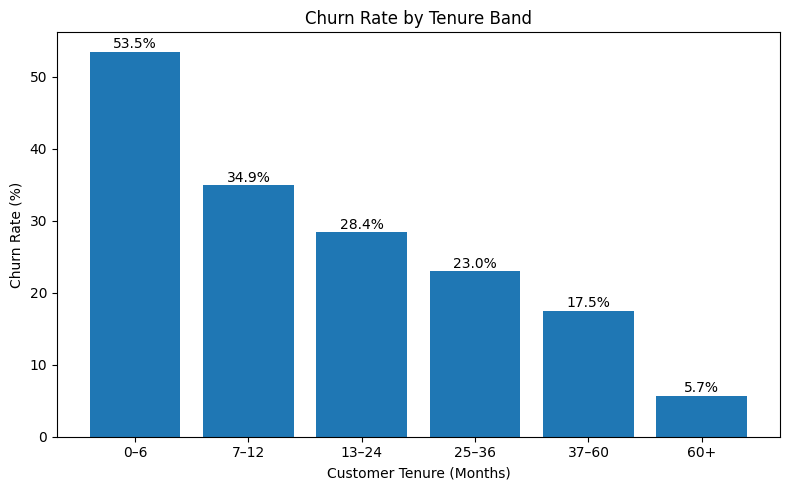

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('/content/telco_churn_train.csv')
df['churn_flag'] = df['Churn']  # 1 = churned, 0 = active

# Create tenure bands (you can adjust the bins/labels)
df['tenure_band'] = pd.cut(
    df['Tenure in Months'],
    bins=[0, 6, 12, 24, 36, 60, 1000],
    labels=['0–6', '7–12', '13–24', '25–36', '37–60', '60+']
)

# Churn rate by tenure band
tenure_churn = (
    df.groupby('tenure_band')['churn_flag']
      .mean()
      .reset_index()
)

tenure_churn['churn_rate_pct'] = tenure_churn['churn_flag'] * 100

plt.figure(figsize=(8, 5))
plt.bar(tenure_churn['tenure_band'], tenure_churn['churn_rate_pct'])

# Show labels on top of each bar
for idx, row in tenure_churn.iterrows():
    plt.text(
        idx,
        row['churn_rate_pct'] + 0.5,
        f"{row['churn_rate_pct']:.1f}%",
        ha='center'
    )

plt.title('Churn Rate by Tenure Band')
plt.xlabel('Customer Tenure (Months)')
plt.ylabel('Churn Rate (%)')
plt.tight_layout()
plt.show()


In [3]:
import pandas as pd
import numpy as np
import pickle

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from xgboost import XGBClassifier


In [4]:
def feature_engineering(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # 1) Under 30
    df["Under 30"] = (df["Age"] < 30).astype(int)

    # 2) Tenure bucket (you can adjust edges/labels if needed)
    df["TenureBucket"] = pd.cut(
        df["Tenure in Months"],
        bins=[0, 12, 24, 36, 48, 60, 120],
        labels=["0-12", "13-24", "25-36", "37-48", "49-60", "61+"],
        include_lowest=True
    )

    # 3) Average monthly from total revenue (avoid division by zero)
    df["AvgMonthlyFromTotal"] = (
        df["Total Revenue"] / df["Tenure in Months"].replace(0, np.nan)
    )

    # 4) Revenue to monthly ratio
    df["RevenueToMonthlyRatio"] = (
        df["Total Revenue"] / df["Monthly Charge"].replace(0, np.nan)
    )

    # 5) Drop strong leakage / ID columns (adjust list to match your training)
    leak_cols = [
        "Customer ID", "Churn Category", "Churn Reason", "Churn Score",
        "Customer Status", "Lat Long", "Latitude", "Longitude", "Zip Code"
    ]
    for c in leak_cols:
        if c in df.columns:
            df = df.drop(columns=c)

    return df


In [5]:
# Load your TRAIN file (raw, not engineered)
df_train = pd.read_csv("telco_churn_train.csv")

# Target as binary
# ----- CORRECT VERSION -----
y_train = df_train["Churn"].astype(int)   # or simply df_train["Churn"]


# Apply feature engineering to get engineered dataframe
df_train_fe = feature_engineering(df_train)

# Drop target column from features
X_train = df_train_fe.drop(columns=["Churn"])


In [6]:
# Identify numeric & categorical after feature engineering
numeric_features = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X_train.select_dtypes(include=["object", "category"]).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)


In [7]:
# Wrap feature_engineering into a FunctionTransformer
fe_step = FunctionTransformer(feature_engineering, validate=False)

clf = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42
)

pipeline = Pipeline(steps=[
    ("feature_engineering", fe_step),
    ("preprocessor", preprocessor),
    ("model", clf)
])


In [8]:
# IMPORTANT: fit on the *raw* df_train (pipeline will engineer features inside)
pipeline.fit(df_train, y_train)


Pipeline(steps=[('feature_engineering',
                 FunctionTransformer(func=<function feature_engineering at 0x7eb4c5b9a980>)),
                ('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age',
                                                   'Avg Monthly GB Download',
                                                   'Avg Monthly Long Distance '
                                                   'Charges',
                                                   'CLTV', 'Dependents',
                                                   'Device P...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=4, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=300, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [9]:
with open("telco_churn_pipeline.pkl", "wb") as f:
    pickle.dump(pipeline, f)


In [10]:
# Load later (in same or different notebook)
import pickle
import pandas as pd

with open("telco_churn_pipeline.pkl", "rb") as f:
    pipeline = pickle.load(f)

df_val = pd.read_csv("telco_churn_validation.csv")
y_val = df_val["Churn"].map({"Yes": 1, "No": 0})

# Get probabilities and predictions directly from RAW validation data
y_proba = pipeline.predict_proba(df_val)[:, 1]
y_pred  = pipeline.predict(df_val)


In [11]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix

# 1. Load validation data (raw)
df_val = pd.read_csv("telco_churn_validation.csv")

# 2. True labels
y_val = df_val["Churn"].astype(int)

# 3. Model predictions and probabilities
y_pred = pipeline.predict(df_val)
y_proba = pipeline.predict_proba(df_val)[:, 1]

# -------------------------------
# A. KPI 1 — Historical Churn Rate
# -------------------------------
historical_churn_rate = y_val.mean() * 100

# -------------------------------
# B. Create Risk Buckets
# -------------------------------
df_val["risk_bucket"] = pd.cut(
    y_proba,
    bins=[0, 0.33, 0.66, 1],
    labels=["Low", "Medium", "High"]
)

# Count high-risk customers
high_risk_customers = (df_val["risk_bucket"] == "High").sum()

# -------------------------------
# C. Confusion Matrix
# -------------------------------
cm = confusion_matrix(y_val, y_pred)
tn, fp, fn, tp = cm.ravel()

# -------------------------------
# D. Assume 20% retention success rate
# -------------------------------
retention_success = 0.20

customers_saved = tp * retention_success

# -------------------------------
# E. Expected Churn AFTER Model
# -------------------------------
new_expected_churners = fn + (tp - customers_saved)

after_model_churn_rate = (new_expected_churners / len(df_val)) * 100

# -------------------------------
# F. Print Results
# -------------------------------
print("KPI 5.1.1 — Churn Rate Analysis")
print("--------------------------------")
print(f"1. Historical Churn Rate (Before Model): {historical_churn_rate:.2f}%")
print(f"2. High-Risk Customers Detected: {high_risk_customers}")
print(f"3. True Positives (churners correctly caught): {tp}")
print(f"4. Customers Saved (20% retention success): {customers_saved:.1f}")
print(f"5. Expected Churn Rate After Model: {after_model_churn_rate:.2f}%")
print()
print(f"Churn Reduction Achieved: {historical_churn_rate - after_model_churn_rate:.2f}%")


KPI 5.1.1 — Churn Rate Analysis
--------------------------------
1. Historical Churn Rate (Before Model): 26.54%
2. High-Risk Customers Detected: 332
3. True Positives (churners correctly caught): 338
4. Customers Saved (20% retention success): 67.6
5. Expected Churn Rate After Model: 21.75%

Churn Reduction Achieved: 4.80%


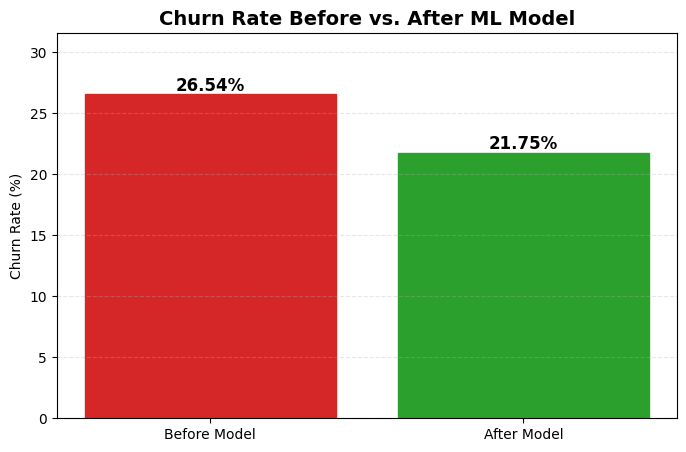

In [12]:
import matplotlib.pyplot as plt

# Values from your KPI results
before = historical_churn_rate
after = after_model_churn_rate

plt.figure(figsize=(8,5))

bars = plt.bar(
    ["Before Model", "After Model"],
    [before, after]
)

# Color coding: red for worse, green for improvement
bars[0].set_color("#d62728")  # red
bars[1].set_color("#2ca02c")  # green

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.3,
        f"{height:.2f}%",
        ha="center",
        fontsize=12,
        fontweight="bold"
    )

plt.title("Churn Rate Before vs. After ML Model", fontsize=14, fontweight="bold")
plt.ylabel("Churn Rate (%)")
plt.ylim(0, max(before, after) + 5)
plt.grid(axis="y", linestyle="--", alpha=0.3)

plt.show()


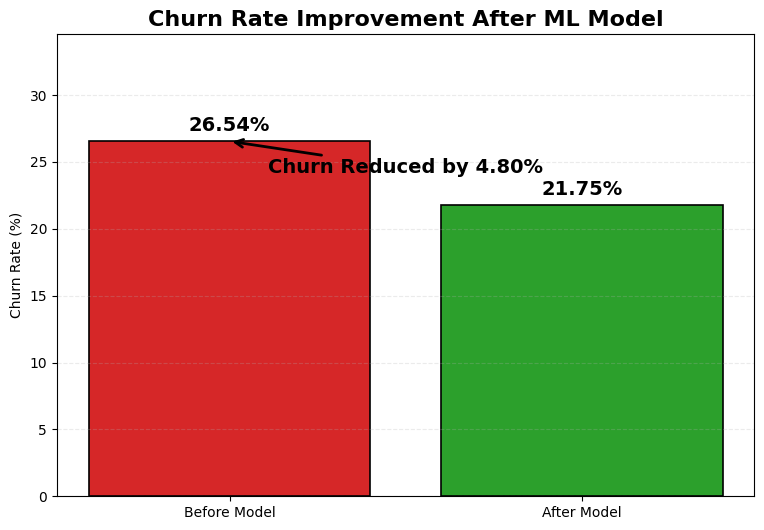

In [ ]:
import matplotlib.pyplot as plt

# Values from your KPI calculations
before = historical_churn_rate
after = after_model_churn_rate
improvement = before - after

plt.figure(figsize=(9,6))

bars = plt.bar(
    ["Before Model", "After Model"],
    [before, after],
    color=["#d62728", "#2ca02c"],
    edgecolor="black",
    linewidth=1.2
)

# Add value labels
plt.text(
    0, before + 0.8, f"{before:.2f}%", ha="center", fontsize=14, fontweight="bold"
)
plt.text(
    1, after + 0.8, f"{after:.2f}%", ha="center", fontsize=14, fontweight="bold"
)

# Add improvement annotation
plt.annotate(
    f"Churn Reduced by {improvement:.2f}%",
    xy=(0, before),
    xytext=(0.5, (before + after) / 2),
    textcoords="data",
    fontsize=14,
    fontweight="bold",
    ha="center",
    arrowprops=dict(arrowstyle="->", lw=2, color="black")
)

plt.title("Churn Rate Improvement After ML Model", fontsize=16, fontweight="bold")
plt.ylabel("Churn Rate (%)")
plt.ylim(0, max(before, after) + 8)
plt.grid(axis="y", linestyle="--", alpha=0.25)

plt.show()


In [13]:
import pandas as pd
import numpy as np

# 1) Load validation data (raw) and true labels
df_val = pd.read_csv("telco_churn_validation.csv")
y_val = df_val["Churn"].astype(int)

# 2) Model probabilities from your trained pipeline
y_proba = pipeline.predict_proba(df_val)[:, 1]

# 3) Masks (use business threshold 0.7)
HIGH_THR = 0.7

is_churner   = (y_val == 1)           # all real churners
is_high_risk = (y_proba >= HIGH_THR)  # predicted High-Risk based on 0.7

# 4) KPI: High-Risk Detection Accuracy (Recall for churners)
tp_high        = np.sum(is_churner & is_high_risk)   # real churners correctly flagged High
total_churners = np.sum(is_churner)                  # all real churners

high_risk_detection_rate = tp_high / total_churners * 100

print(f"High-Risk Detection Accuracy (thr=0.7): {high_risk_detection_rate:.2f}%")
print(f"Churners correctly flagged High-Risk: {tp_high} / {total_churners}")


High-Risk Detection Accuracy (thr=0.7): 86.10%
Churners correctly flagged High-Risk: 322 / 374


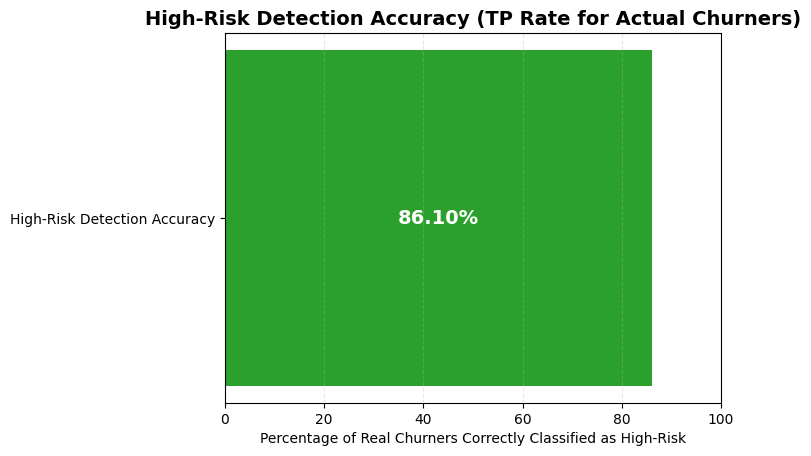

In [15]:
value = high_risk_detection_rate
plt.barh("High-Risk Detection Accuracy", value,
         color="#2ca02c" if value >= 70 else "#d62728")

# Optional: Add axis labels and title for clarity, similar to cell W9ZYbgjvQioC
plt.xlim(0, 100)

# Add label inside bar
plt.text(value/2, 0, f"{value:.2f}%",
         ha="center", va="center",
         fontsize=14, fontweight="bold", color="white")

plt.title("High-Risk Detection Accuracy (TP Rate for Actual Churners)",
          fontsize=14, fontweight="bold")

plt.xlabel("Percentage of Real Churners Correctly Classified as High-Risk")
plt.grid(axis="x", linestyle="--", alpha=0.3)

plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Parameters
threshold = 0.74
retain_rate = 0.20        # 20% of targeted churners are saved
saved_revenue = 200       # $200 revenue per saved churner
campaign_cost_per_cust = 20  # $20 incentive per targeted customer

# Predictions at chosen threshold
y_pred_thr = (y_proba >= threshold).astype(int)

tn, fp, fn, tp = confusion_matrix(y_val, y_pred_thr).ravel()

# Campaign cost: we spend on everyone we target (TP + FP)
n_targeted = tp + fp
campaign_cost = n_targeted * campaign_cost_per_cust

# Revenue saved: only a fraction of TP are actually retained
revenue_saved = tp * retain_rate * saved_revenue

roi = (revenue_saved - campaign_cost) / campaign_cost

print(f"Threshold: {threshold}")
print(f"TP={tp}, FP={fp}, FN={fn}, TN={tn}")
print(f"Targeted customers: {n_targeted}")
print(f"Revenue Saved: ${revenue_saved:,.0f}")
print(f"Campaign Cost: ${campaign_cost:,.0f}")
print(f"Retention ROI: {roi*100:.2f}%")


Threshold: 0.74
TP=319, FP=3, FN=55, TN=1032
Targeted customers: 322
Revenue Saved: $12,760
Campaign Cost: $6,440
Retention ROI: 98.14%


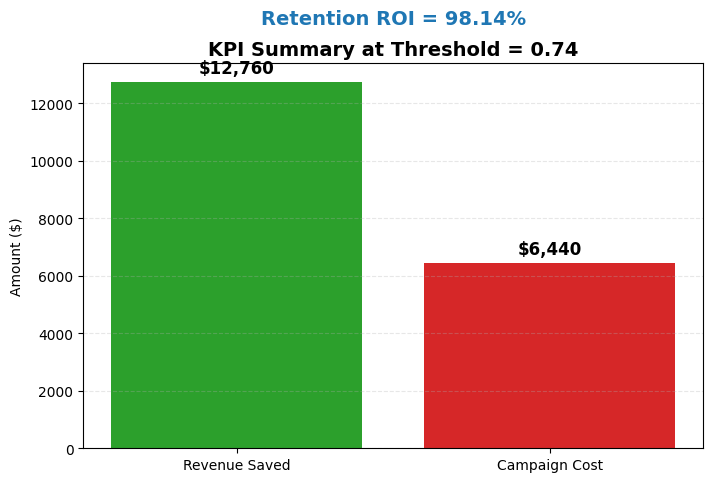

In [ ]:
import matplotlib.pyplot as plt

# Values from your output
threshold = 0.74
tp = 319
fp = 3
fn = 55
tn = 1032
targeted = 322

revenue_saved = 12760
campaign_cost = 6440
roi = 98.14   # percent

# --- Create bar chart ---

fig, ax1 = plt.subplots(figsize=(8,5))

# Bar values
bars = ['Revenue Saved', 'Campaign Cost']
values = [revenue_saved, campaign_cost]
colors = ['#2ca02c', '#d62728']  # green, red

plt.bar(bars, values, color=colors)

# Add labels on bars
for i, v in enumerate(values):
    plt.text(i, v + 300, f"${v:,.0f}", ha='center', fontsize=12, fontweight='bold')

plt.title(f"KPI Summary at Threshold = {threshold}", fontsize=14, fontweight="bold")
plt.ylabel("Amount ($)")
plt.grid(axis='y', linestyle='--', alpha=0.3)

# --- Add ROI annotation ---
plt.text(0.5, max(values) + 2000,
         f"Retention ROI = {roi:.2f}%",
         ha='center', fontsize=14, fontweight='bold', color='#1f77b4')

plt.show()


Best ROI threshold: 0.92, ROI = 100.00%


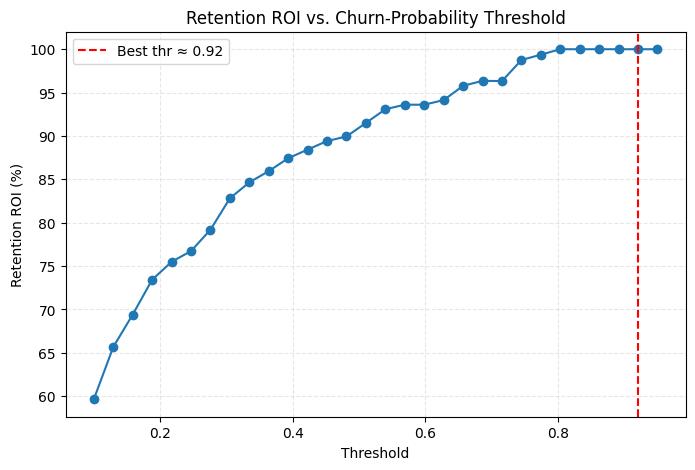

In [ ]:
import matplotlib.pyplot as plt

thresholds = np.linspace(0.1, 0.95, 30)
rois = []

for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred_t).ravel()

    n_targeted = tp + fp
    if n_targeted == 0:
        rois.append(np.nan)
        continue

    campaign_cost = n_targeted * campaign_cost_per_cust
    revenue_saved = tp * retain_rate * saved_revenue
    roi_t = (revenue_saved - campaign_cost) / campaign_cost
    rois.append(roi_t)

# Best threshold by ROI
best_idx = np.nanargmax(rois)
best_thr = thresholds[best_idx]
best_roi = rois[best_idx]

print(f"Best ROI threshold: {best_thr:.2f}, ROI = {best_roi*100:.2f}%")

plt.figure(figsize=(8,5))
plt.plot(thresholds, np.array(rois)*100, marker="o")
plt.axvline(best_thr, color="red", linestyle="--", label=f"Best thr ≈ {best_thr:.2f}")
plt.xlabel("Threshold")
plt.ylabel("Retention ROI (%)")
plt.title("Retention ROI vs. Churn-Probability Threshold")
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend()
plt.show()


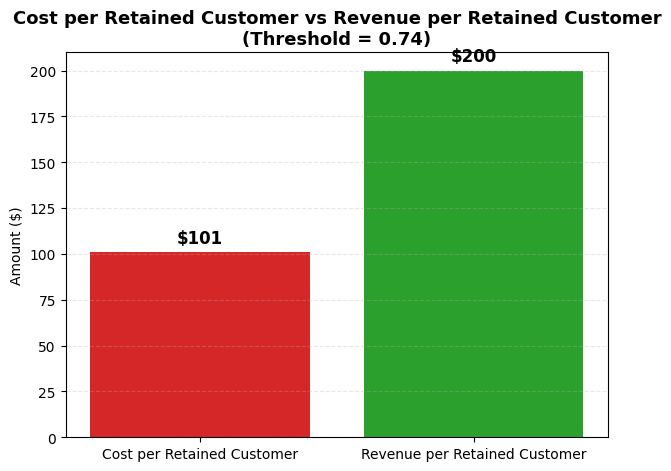

In [ ]:
import matplotlib.pyplot as plt

# Example numbers – replace with your actual values from threshold 0.74
tp = 319
retain_rate = 0.20
campaign_cost = 6440       # from your earlier result
revenue_per_customer = 200 # revenue saved per retained churner

customers_saved = tp * retain_rate
cost_per_retained = campaign_cost / customers_saved

labels = ["Cost per Retained Customer", "Revenue per Retained Customer"]
values = [cost_per_retained, revenue_per_customer]
colors = ["#d62728", "#2ca02c"]  # red cost, green revenue

plt.figure(figsize=(7,5))
bars = plt.bar(labels, values, color=colors)

# add value labels
for bar, v in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2,
             v + 5,
             f"${v:,.0f}",
             ha="center",
             fontsize=12,
             fontweight="bold")

plt.title("Cost per Retained Customer vs Revenue per Retained Customer\n(Threshold = 0.74)",
          fontsize=13, fontweight="bold")
plt.ylabel("Amount ($)")
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.show()


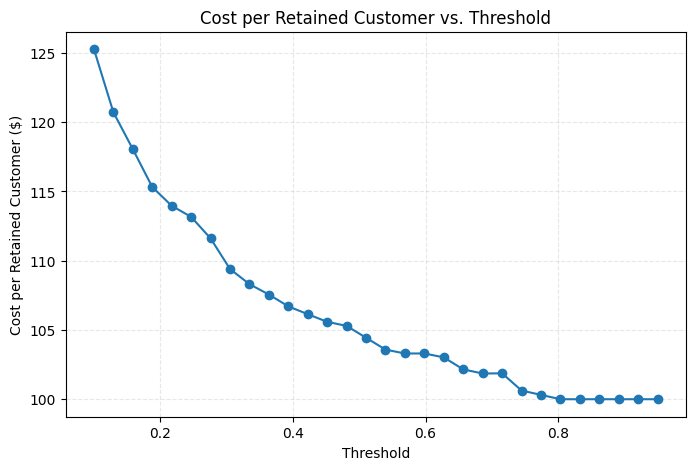

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

retain_rate = 0.20
incentive_cost = 20
saved_revenue = 200

thresholds = np.linspace(0.1, 0.95, 30)
cost_per_retained_list = []

for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred_t).ravel()

    targeted = tp + fp
    customers_saved = tp * retain_rate

    if customers_saved == 0:
        cost_per_retained_list.append(np.nan)
        continue

    campaign_cost = targeted * incentive_cost
    cpr = campaign_cost / customers_saved
    cost_per_retained_list.append(cpr)

plt.figure(figsize=(8,5))
plt.plot(thresholds, cost_per_retained_list, marker="o")
plt.xlabel("Threshold")
plt.ylabel("Cost per Retained Customer ($)")
plt.title("Cost per Retained Customer vs. Threshold")
plt.grid(True, linestyle="--", alpha=0.3)
plt.show()


In [ ]:
df_val.columns


Index(['Age', 'Avg Monthly GB Download', 'Avg Monthly Long Distance Charges',
       'Churn', 'Churn Category', 'Churn Reason', 'Churn Score', 'City',
       'CLTV', 'Contract', 'Country', 'Customer ID', 'Customer Status',
       'Dependents', 'Device Protection Plan', 'Gender', 'Internet Service',
       'Internet Type', 'Lat Long', 'Latitude', 'Longitude', 'Married',
       'Monthly Charge', 'Multiple Lines', 'Number of Dependents',
       'Number of Referrals', 'Offer', 'Online Backup', 'Online Security',
       'Paperless Billing', 'Partner', 'Payment Method', 'Phone Service',
       'Population', 'Premium Tech Support', 'Quarter', 'Referred a Friend',
       'Satisfaction Score', 'Senior Citizen', 'State', 'Streaming Movies',
       'Streaming Music', 'Streaming TV', 'Tenure in Months', 'Total Charges',
       'Total Extra Data Charges', 'Total Long Distance Charges',
       'Total Refunds', 'Total Revenue', 'Under 30', 'Unlimited Data',
       'Zip Code', 'risk_bucket', 'is_churn

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

retain_rate = 0.20  # 20% retention success

# 0) Use Total Revenue as numeric LTV
df_val["LTV_final"] = pd.to_numeric(df_val["Total Revenue"], errors="coerce")

# 1) Total LTV of all churners (LTV at risk)
churners = df_val[df_val["is_churner"] == 1]           # <-- use is_churner
total_ltv_churners = churners["LTV_final"].sum()

# 2) LTV of churners that the model flags as High-Risk
high_risk_churners = df_val[(df_val["is_churner"] == 1) &
                            (df_val["risk_bucket"] == "High")]
ltv_high_risk_churners = high_risk_churners["LTV_final"].sum()

# 3) Expected LTV preserved by the model (only a fraction are actually retained)
ltv_preserved = ltv_high_risk_churners * retain_rate

print(f"Total LTV at Risk (churners): ${total_ltv_churners:,.0f}")
print(f"LTV of High-Risk Churners:     ${ltv_high_risk_churners:,.0f}")
print(f"Expected LTV Preserved:       ${ltv_preserved:,.0f}")




Total LTV at Risk (churners): $769,589
LTV of High-Risk Churners:     $655,134
Expected LTV Preserved:       $131,027


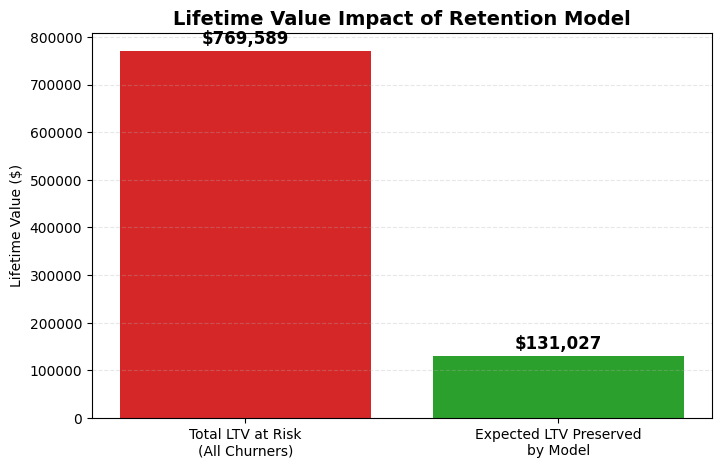

In [ ]:
labels = ["Total LTV at Risk\n(All Churners)",
          "Expected LTV Preserved\nby Model"]

values = [total_ltv_churners, ltv_preserved]
colors = ["#d62728", "#2ca02c"]  # red = risk, green = preserved

plt.figure(figsize=(8,5))
bars = plt.bar(labels, values, color=colors)

for bar, v in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2,
             v + 0.02 * max(values),
             f"${v:,.0f}",
             ha="center", fontsize=12, fontweight="bold")

plt.title("Lifetime Value Impact of Retention Model", fontsize=14, fontweight="bold")
plt.ylabel("Lifetime Value ($)")
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()

